In [51]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from TMaze_new.TMaze_new_src.utils.tmaze import TMazeClassicPassive
from TMaze_new.TMaze_new_src.utils import seeds_list

In [48]:
def get_returns_TMaze_Ranom(ret, seed, episode_timeout, corridor_length, create_video=False):
    
    channels = 5
    max_ep_len = episode_timeout

    env = TMazeClassicPassive(episode_length=episode_timeout, corridor_length=corridor_length, penalty=0, seed=seed, goal_reward=ret)
    state = env.reset() # {x, y, hint}
    np.random.seed(seed)
    where_i = state[0]
    mem_state = state[2]
    mem_state2 = state

    state = np.concatenate((state, np.array([0]))) # {x, y, hint, flag}
    state = np.concatenate((state, np.array([np.random.randint(low=-1, high=1+1)]))) # {x, y, hint, flag, noise}

    if create_video == True:
        print("down, required act: 3" if mem_state == -1.0 else "up,  required act: 1")

    state = torch.tensor(state).reshape(1, 1, channels)
    out_states = []
    out_states.append(state.cpu().numpy())
    done = True
    Flag = 0
    
    rews = []
    episode_return, episode_length = 0, 0
    act = None
    act_list= []

    
    for t in range(max_ep_len):
        act = np.random.randint(low=0, high=3+1)
        act_list.append(act)
        state, reward, done, info = env.step(act)
        
         # {x, y, hint} -> {x, y, hint, flag}
        if state[0] != env.corridor_length:
            state = np.concatenate((state, np.array([0])))
        else:
            if Flag != 1:
                state = np.concatenate((state, np.array([1])))
                Flag = 1
            else:
                state = np.concatenate((state, np.array([0])))
                
        # {x, y, hint, flag} -> {x, y, hint, flag, noise}
        state = np.concatenate((state, np.array([np.random.randint(low=-1, high=1+1)])))
        
        
        delta_t = env.time_step - env.corridor_length - 1
        where_i = state[0]
        state = state.reshape(1, 1, channels)
        out_states.append(state)
        
        rews.append(reward)
        episode_return += reward
        episode_length += 1
    
            
        if done:
            if create_video == True:
                if np.round(where_i, 4) == np.round(corridor_length, 4):
                    print("Junction achieved 😀 ✅✅✅")
                    print("Chosen act:", "up" if act == 1 else "down" if act == 3 else "wrong")
                    if mem_state == -1 and act == 3:
                        print("Correct choice 😀 ✅✅✅")
                    elif mem_state == 1 and act == 1:
                        print("Correct choice 😀 ✅✅✅")
                    else:
                        print("Wrong choice 😭 ⛔️⛔️⛔️")
                else:
                    print("Junction is not achieved 😭 ⛔️⛔️⛔️")
                
            break
        
    return reward, act_list, t, np.array(out_states).squeeze(), delta_t

In [49]:
means = []
for T in tqdm(range(3, 901)):
    rews = []
    for SEED in seeds_list:
        reward, act_list, t, states, delta_t = get_returns_TMaze_Ranom(ret=1.0, seed=SEED, episode_timeout=T, corridor_length=T-2, create_video=False)

        rews.append(reward)

    means.append(np.mean(rews))

100%|██████████| 898/898 [12:06<00:00,  1.24it/s]


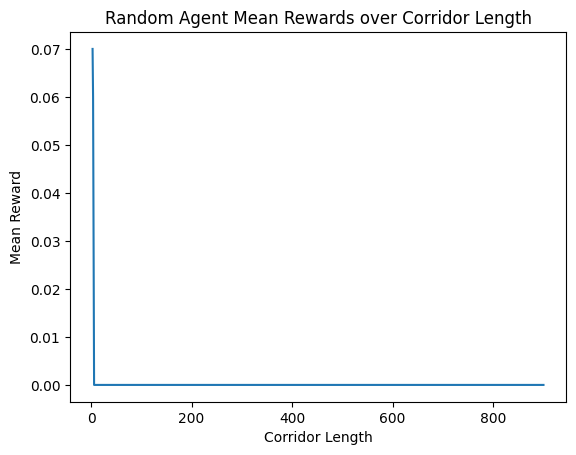

In [55]:
plt.plot(range(3, 901), means)
plt.title('Random Agent Mean Rewards over Corridor Length')
plt.xlabel('Corridor Length')
plt.ylabel('Mean Reward')
plt.show()